In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import imp
import pymc3 as pm

pm.__version__

Couldn't import dot_parser, loading of dot files will not be possible.


'3.0'

# Multiple Treatment Meta-analysis for ASD Interventions

As many of the interventions involve combinations of paradigms we identified categories that would best describe these combinations. Each intervention is described as involving the following elements, with some involving more than one.  

- **High Intensity ABA** Greater than 10 hours of EIBI as part of intervention (inclusive of UCLA/Lovaas, ESDM, EIBI variants).
- **Low Intensity ABA** Less than 10 hours of EIBI or variants.
- **Low intensity parent training** Less than 5 hours per week of parent training.
- **Defined school program** A formal, designated school enrollment as part of intervention.
- **Eclectic school** Involvement in preschool with content unspecified.
- **Community high intensity** Documented eclectic service provision in community of greater than 10 hours of service
- **Adjunctive community service** Eclectic service provision unspecified or less than 10 hours of service

In [2]:
# Import data
cognition = pd.read_csv('data/Cognition.csv', 
                             na_values=['NR', 'nr', 'Varied see comment', 'Varied', 'see comment'],
                             index_col=0)

In [3]:
cognition_outcomes = pd.read_csv('data/Cognition_outcomes.csv', index_col=0) 

In [4]:
# replace some values
cognition = cognition.replace({'immed': 0})
cognition.time_to_last_fup = cognition.time_to_last_fup.astype(float)

Missing diagnosis values should be zero

In [5]:
diagnoses = ['diagnosis_autism', 'diagnosis_pdd-nos', 'diagnosis_asperger', 'diagnosis_other']
cognition[diagnoses] = cognition[diagnoses].fillna(0)

In [6]:
cognition_outcomes.cognition_outcome.unique().shape

(31,)

In [7]:
cognition_outcomes.cognition_outcome = cognition_outcomes.cognition_outcome.replace(
                    ['IQ', 'Early learning composite', 'Intellectual functioning',
                    'MDI', 'cognitive standard', 'Full scale IQ',
                    'DQ', 'GMDS-ER GQ', 'Early Learning composite'], 'IQ Standard Score') 

cognition_outcomes.cognition_outcome = cognition_outcomes.cognition_outcome.replace(
                    ['mental age', 'dev age', 'Developmental age'], 'IQ Age Scale')

cognition_outcomes.cognition_outcome = cognition_outcomes.cognition_outcome.replace(
                    ['Non-Verbal IQ', 'non-verbal IQ', 'Performance IQ',
                    'Nonverbal IQ', 'Non-verbal', 'Non-verbal intelligence', 
                    'non-verbal cognition (VR)', 'Visual', 'Visual-spatial IQ', 
                    'Visual reception'], 'Non-verbal IQ')

cognition_outcomes.cognition_outcome = cognition_outcomes.cognition_outcome.replace('Fine motor', 
                                                                                    'Motor IQ')

cognition_outcomes.cognition_outcome = cognition_outcomes.cognition_outcome.replace(
                    ['Receptive Language', 'Receptive language', 'Expressive language'], 
                    'Language IQ')

cognition_outcomes.cognition_outcome = cognition_outcomes.cognition_outcome.replace(
                    'Expressive language age', 'Language Age Scale')

Drop outcomes that cannot be categorized

In [8]:
cognition_outcomes = cognition_outcomes[cognition_outcomes.cognition_outcome.isin(
    ['Language and communication', 'Reciprocal social interaction']) ^ True]

Drop null outcomes

In [9]:
cognition_outcomes = cognition_outcomes[cognition_outcomes.cognition_outcome.notnull()]

Confirm replacement of values

In [10]:
cognition_outcomes.cognition_outcome.unique()

array(['IQ Standard Score', 'Language Age Scale', 'Language IQ',
       'Non-verbal IQ', 'IQ Age Scale', 'Motor IQ'], dtype=object)

In [11]:
cognition_outcomes.head()

,obsid,cognition_outcome,tool,baseline_mean,baseline_sd,end_tx_mean,end_tx_sd,final_mean,final_sd,change_mean,change_sd
outcomeid,,,,,,,,,,,
1,1,IQ Standard Score,Stanford-Binet and Bayley scale,61.43,16.43,73.48,27.28,64.65,33.04,NaN,NaN
2,2,IQ Standard Score,Stanford-Binet and Bayley scale,63.83,13.98,61.00,27.30,61.94,31.09,NaN,NaN
3,3,IQ Standard Score,Mullen,59.60,6.90,68.50,7.50,NaN,NaN,8.9,NaN
4,4,IQ Standard Score,Mullen,63.20,6.60,61.40,9.00,NaN,NaN,-1.8,NaN
5,5,IQ Standard Score,"BSID, SB:FE, Weschler",51.60,16.90,NaN,NaN,66.60,24.80,NaN,NaN


Confirm numeric types throughout

In [12]:
cognition_outcomes.dtypes

obsid                  int64
cognition_outcome     object
tool                  object
baseline_mean        float64
baseline_sd          float64
end_tx_mean          float64
end_tx_sd            float64
final_mean           float64
final_sd             float64
change_mean          float64
change_sd            float64
dtype: object

Counts of unique treatments (treatment names)

In [13]:
cognition.treatment.value_counts()

Eclectic                                        4
TAU                                             3
EIBI                                            3
ABA                                             3
Parent training                                 2
control / TAU                                   2
Clinic based\nABA                               1
P-ESDM                                          1
intensive behavior\nanalytic (IBT)              1
behavioral                                      1
Parent directed                                 1
EIBT-UCLA                                       1
Clinic directed                                 1
Parent\nmanaged\nABA                            1
Local services                                  1
HTMW                                            1
Control                                         1
Intensive Rx-\nUCLA                             1
Community based Rx                              1
LEAP                                            1


Counts of unique tools

In [14]:
cognition_outcomes.tool.value_counts()

MSEL                                    24
Mullen                                   8
Merrill-Palmer                           8
composite                                5
PEP-R                                    4
GSID                                     2
WPPSI-R/WISC-R/BSID                      2
BSID, SB:FE, Weschler                    2
Griffith mental developmental scales     2
MPSMT                                    2
Stanford Binet and BSID-II               2
Bayley-Dutch version                     2
Bayley and WPPSI-R                       2
Bayley and Merrill-Palmer                2
Bayley, Merrill-Palmer                   2
Bayley                                   2
BSID-II                                  2
Bayley, Stanford-Binet                   2
Stanford-Binet and Bayley scale          2
Merrill Palmer                           1
Name: tool, dtype: int64

Counts of outcome measures used

In [15]:
cognition_outcomes.cognition_outcome.value_counts()

IQ Standard Score     33
Non-verbal IQ         21
Language IQ           12
IQ Age Scale           6
Motor IQ               4
Language Age Scale     2
Name: cognition_outcome, dtype: int64

## Build intervention network

List of intervention classes

In [16]:
intervention_types = ['high_intensity_eibi', 'low_intensity_eibi',
       'low_intensity_parent_training', 'defined_school_program',
       'high_intensity_community', 'adjunctive_community_service',
       'eclectic_school']

Create edges for network using all pairwise combinations of interventions

In [17]:
import itertools

network_edges = list(itertools.combinations(intervention_types, 2))

Initialize network

In [18]:
network = dict.fromkeys(network_edges, 0)
for i in intervention_types:
    network[(i, i)] = 0

Create parallel network for sample size

In [19]:
sample_size = network.copy()

Populate network dicts

In [20]:
# Loop over all studies
for s in cognition.refid.unique():
    
    # Construct pairs of comparisons
    study = cognition[cognition.refid==s]
    study_interventions = study[intervention_types].sum()
    # Get sample sizes
    studies = cognition[cognition.refid==s]
    n_analysis = studies.n_analysis
    
    # Generate pairs of interventions for this study
    pairs = list(itertools.combinations(study_interventions.index[study_interventions==1].values, 2))
    
    # Loop over pairs within study, and increment comparison count
    for pair in pairs:
        
        network[pair] += 1

        sample_size[pair] += n_analysis[cognition[cognition.refid==s][pair[0]]==1].values[0]
        sample_size[pair] += n_analysis[cognition[cognition.refid==s][pair[1]]==1].values[0]
        
    
    # Account for comparisons within a class
    within_comparisons = study_interventions[study_interventions==2].index.values
    for c in within_comparisons:
        network[(c, c)] += 1
        sample_size[(c, c)] += n_analysis[cognition[cognition.refid==s][c]==1].values[0]
        sample_size[(c, c)] += n_analysis[cognition[cognition.refid==s][c]==1].values[1]
        
nonzero_network = {tuple(ni.replace('_', ' ') for ni in n): network[n] for n in network if network[n]}
nonzero_samples = {tuple(ni.replace('_', ' ') for ni in n): sample_size[n] for n in sample_size if sample_size[n]}

Number of studies with direct comparisons between pairs of interventions

In [21]:
nonzero_network

{('adjunctive community service', 'adjunctive community service'): 1,
 ('adjunctive community service', 'eclectic school'): 1,
 ('defined school program', 'adjunctive community service'): 2,
 ('defined school program', 'defined school program'): 2,
 ('defined school program', 'eclectic school'): 3,
 ('eclectic school', 'eclectic school'): 1,
 ('high intensity community', 'eclectic school'): 1,
 ('high intensity eibi', 'adjunctive community service'): 3,
 ('high intensity eibi', 'defined school program'): 4,
 ('high intensity eibi', 'eclectic school'): 3,
 ('high intensity eibi', 'high intensity community'): 2,
 ('high intensity eibi', 'high intensity eibi'): 3,
 ('high intensity eibi', 'low intensity parent training'): 1,
 ('low intensity eibi', 'eclectic school'): 1,
 ('low intensity parent training', 'adjunctive community service'): 3,
 ('low intensity parent training', 'defined school program'): 1,
 ('low intensity parent training', 'eclectic school'): 1}

Sample sizes for each comparison

In [22]:
nonzero_samples

{('adjunctive community service', 'adjunctive community service'): 152,
 ('adjunctive community service', 'eclectic school'): 31,
 ('defined school program', 'adjunctive community service'): 77,
 ('defined school program', 'defined school program'): 112,
 ('defined school program', 'eclectic school'): 112,
 ('eclectic school', 'eclectic school'): 41,
 ('high intensity community', 'eclectic school'): 32,
 ('high intensity eibi', 'adjunctive community service'): 111,
 ('high intensity eibi', 'defined school program'): 184,
 ('high intensity eibi', 'eclectic school'): 105,
 ('high intensity eibi', 'high intensity community'): 90,
 ('high intensity eibi', 'high intensity eibi'): 90,
 ('high intensity eibi', 'low intensity parent training'): 28,
 ('low intensity eibi', 'eclectic school'): 40,
 ('low intensity parent training', 'adjunctive community service'): 172,
 ('low intensity parent training', 'defined school program'): 48,
 ('low intensity parent training', 'eclectic school'): 26}

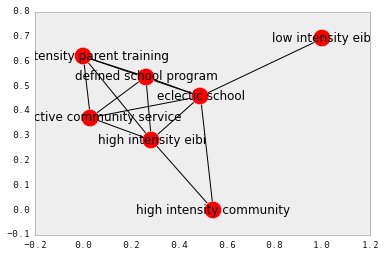

In [49]:
import networkx as nx

G = nx.Graph()

for n in nonzero_network:
    G.add_edge(n[0], n[1] ,weight=nonzero_network[n])
    
nx.draw_networkx(G) #, prog="twopi")

In [35]:
G.get_edge_data?

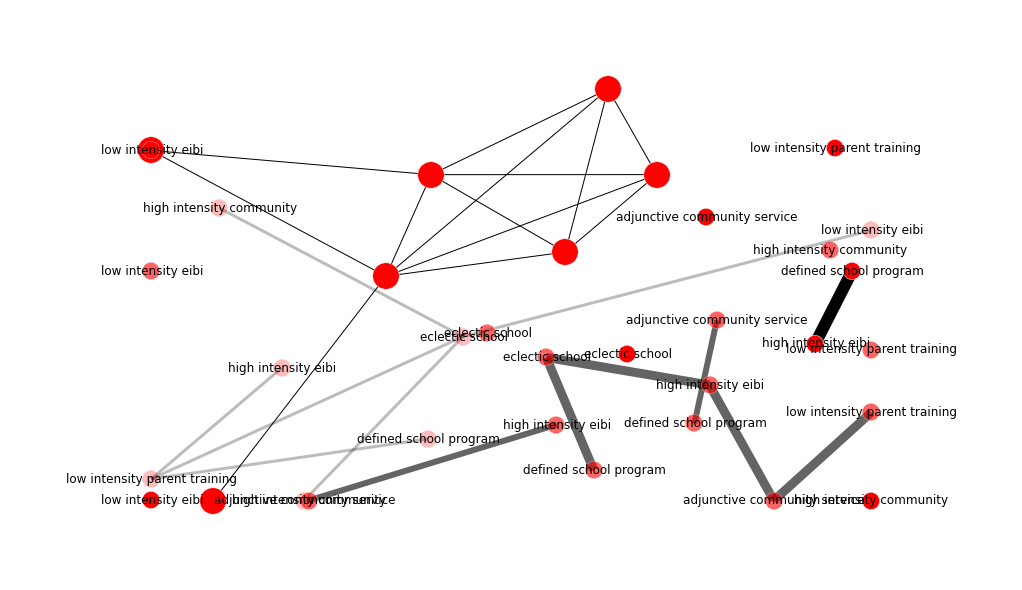

In [48]:
plt.figure(figsize=(14,8))
nx.draw(G, pos,node_size=700)

nmax = float(max(nonzero_samples.values()))

for i in range(max(nonzero_network.values())):
    # Generate edge with appropriate weight
    edge_i = [(u,v) for (u,v,d) in G.edges(data=True) if d['weight']==(i+1)]
    # Generate alpha for edges
    try:
        alpha = nonzero_samples[edge_i[0]] / nmax
    except KeyError:
        # Sometimes the pairs are backwards
        alpha = nonzero_samples[edge_i[0][::-1]] / nmax
    nx.draw_networkx(G, pos, edgelist=edge_i, width=(i+1)*3, alpha=alpha)
#nx.draw_networkx_labels(G, pos_shifted, font_size=10, font_family='sans-serif')
plt.gca().xaxis.set_major_locator(plt.NullLocator())
plt.gca().yaxis.set_major_locator(plt.NullLocator());

Merge study information and outcomes

In [37]:
# Columns from the cognition table that we are interested in
cols_to_keep = ['refid', 'author', 'year', 'treatment', 
       'high_intensity_eibi', 'low_intensity_eibi',
       'low_intensity_parent_training', 'defined_school_program',
       'high_intensity_community', 'adjunctive_community_service',
       'eclectic_school', 'intervention_duration', 
       'n_analysis', 'age_enroll_mean', 'age_enroll_sd',
       'age_enroll_lo', 'age_enroll_hi', 'diagnosis_autism',
       'diagnosis_pdd-nos', 'diagnosis_asperger', 'diagnosis_other']

In [38]:
cognition_data = cognition[cols_to_keep].merge(cognition_outcomes, left_index=True, right_on='obsid')

Export and peek at merged dataset

In [39]:
cognition_data.to_csv('data/cognition_merged.csv')
cognition_data.head()

,refid,author,year,treatment,high_intensity_eibi,low_intensity_eibi,low_intensity_parent_training,defined_school_program,high_intensity_community,adjunctive_community_service,...,cognition_outcome,tool,baseline_mean,baseline_sd,end_tx_mean,end_tx_sd,final_mean,final_sd,change_mean,change_sd
outcomeid,,,,,,,,,,,,,,,,,,,,,
1,6276_240,Kovshoff,2011,EIBI,1,0,0,0,0,0,...,IQ Standard Score,Stanford-Binet and Bayley scale,61.43,16.43,73.48,27.28,64.65,33.04,NaN,NaN
49,6276_240,Kovshoff,2011,EIBI,1,0,0,0,0,0,...,IQ Age Scale,Bayley,22.04,6.89,33.70,10.16,44.39,16.39,NaN,NaN
2,6276_240,Kovshoff,2011,Control,0,0,0,0,0,1,...,IQ Standard Score,Stanford-Binet and Bayley scale,63.83,13.98,61.00,27.30,61.94,31.09,NaN,NaN
50,6276_240,Kovshoff,2011,Control,0,0,0,0,0,1,...,IQ Age Scale,Bayley,23.71,6.00,29.81,9.89,38.00,17.44,NaN,NaN
3,6493,Strain,2011,LEAP,0,0,0,1,0,0,...,IQ Standard Score,Mullen,59.60,6.90,68.50,7.50,NaN,NaN,8.9,NaN


## Build outcome network

Another network to display the number of studies that contain multiple outcome measures, which allows us to relate outcomes to one another.

In [40]:
outcome_types = cognition_outcomes.cognition_outcome.unique()
outcome_types

array(['IQ Standard Score', 'Language Age Scale', 'Language IQ',
       'Non-verbal IQ', 'IQ Age Scale', 'Motor IQ'], dtype=object)

Calculate set of edges

In [41]:
outcome_network_edges = list(itertools.combinations(outcome_types, 2))

Initialize network

In [42]:
outcome_network = dict.fromkeys(outcome_network_edges, 0)
for i in outcome_types:
    outcome_network[(i, i)] = 0

The set of comparisons in each study

In [43]:
outcome_comparisons = cognition_data.groupby('refid')['cognition_outcome'].unique()
outcome_comparisons

refid
1117                                           [Non-verbal IQ]
1264                         [IQ Standard Score, IQ Age Scale]
546                         [IQ Standard Score, Non-verbal IQ]
5652                                       [IQ Standard Score]
5680                        [IQ Standard Score, Non-verbal IQ]
5715                                       [IQ Standard Score]
588                         [IQ Standard Score, Non-verbal IQ]
6245_6549                                  [IQ Standard Score]
6276_240                     [IQ Standard Score, IQ Age Scale]
6284                                       [IQ Standard Score]
6288                         [Language Age Scale, Language IQ]
6304_8035                         [Language IQ, Non-verbal IQ]
6322                                       [IQ Standard Score]
6427                                       [IQ Standard Score]
647                         [IQ Standard Score, Non-verbal IQ]
6493                                       [IQ St

In [44]:
# Loop over all studies
for oc in outcome_comparisons:
    
    # Generate pairs of interventions for this study
    pairs = list(itertools.combinations(oc, 2))
    
    # Loop over pairs within study, and increment comparison count
    for pair in pairs:
        
        try:
            outcome_network[pair] += 1
        except KeyError:
            outcome_network[pair[::-1]] += 1

In [ ]:
nx.dr

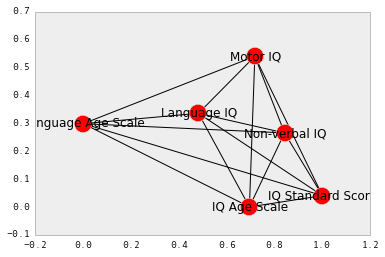

In [47]:
G2 = nx.Graph()

for n in outcome_network:
    G2.add_edge(n[0], n[1], weight=outcome_network[n])
    
nx.draw_networkx(G2) #, prog="twopi")

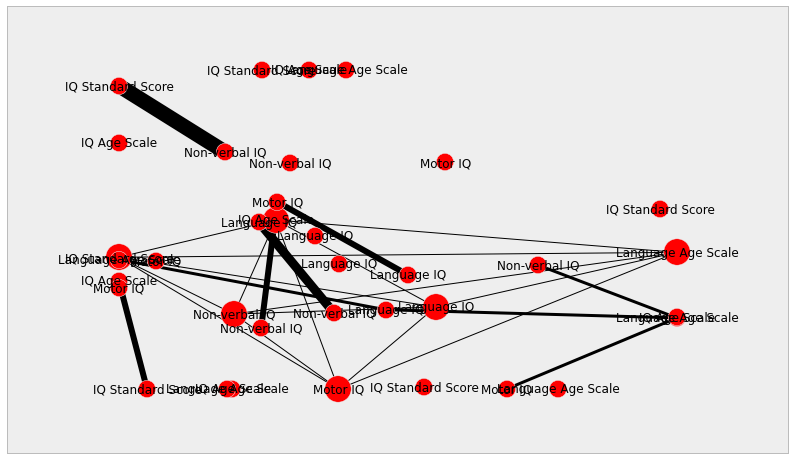

In [52]:
plt.figure(figsize=(14,8))
nx.draw_networkx(G2, pos2, node_size=700)

for i in range(max(outcome_network.values())):
    # Generate edge with appropriate weight
    edge_i = [(u,v) for (u,v,d) in G2.edges(data=True) if d['weight']==(i+1)]
    
    nx.draw_networkx(G2, pos2, edgelist=edge_i, width=(i+1)*3)
    
# pos_shifted2 = {p: (pos2[p][0], pos2[p][1]+10) for p in pos2}
# nx.draw_networkx_labels(G2, pos_shifted2, font_size=10, font_family='sans-serif')
plt.gca().xaxis.set_major_locator(plt.NullLocator())
plt.gca().yaxis.set_major_locator(plt.NullLocator());

Histogram of outcome values across outcomes

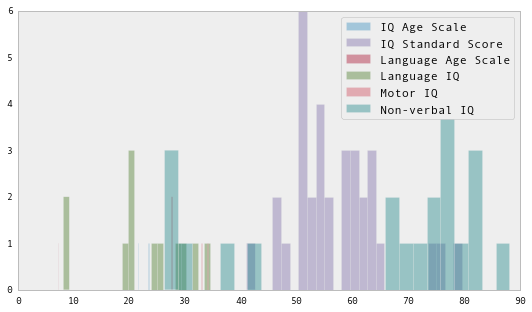

In [53]:
plt.figure(figsize=(9,5))
plot_axes = cognition_data.groupby('cognition_outcome')['baseline_mean'].hist(bins=25, grid=False, alpha=0.4)
plt.legend(plot_axes.index)

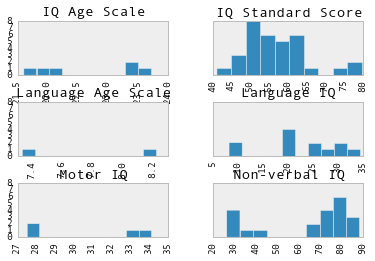

In [54]:
cognition_data['baseline_mean'].hist(by=cognition_data['cognition_outcome'], sharey=True, sharex=False, bins=10);

From the above, it is clear that there is little information in the age scale outcomes and in motor IQ, so we will restrict attention to the other three outcome measures.

In [55]:
outcomes_MA = ['IQ Standard Score', 'Language IQ', 'Non-verbal IQ']

In [56]:
cognition_data_MA = cognition_data[cognition_data.cognition_outcome.isin(outcomes_MA)]

Drop Zachor 2007 since there is no post-treatement value for the included outcome

In [57]:
cognition_data_MA = cognition_data_MA[cognition_data_MA.refid!='5652']

Eliminate `change_mean` values for 6493 since it has no corresponding variance

In [58]:
cognition_data_MA.change_mean[cognition_data_MA.refid=='6493'] = np.nan

Drop 546 because it has no variance for treatment mean

In [59]:
cognition_data_MA = cognition_data_MA[cognition_data_MA.refid!='546']

In [60]:
cognition_data_MA[intervention_types].sum(0)

high_intensity_eibi              23
low_intensity_eibi                4
low_intensity_parent_training     6
defined_school_program           15
high_intensity_community          3
adjunctive_community_service      6
eclectic_school                  11
dtype: int64

## Multiple Treatment Comparison MA model

Create indicators for study, intervention, outcome

In [61]:
unique_studies = cognition_data_MA.refid.unique()
cognition_data_MA['study_id'] = np.squeeze([np.where(r==unique_studies) for r in cognition_data_MA.refid])

In [62]:
np.sort(cognition_data_MA.treatment.apply(lambda x: x.upper()).unique()).tolist()

['ABA',
 'ASSESS & MONITOR GROUP',
 'BEHAVIORAL',
 'CLINIC BASED\nABA',
 'CLINIC DIRECTED',
 'COMMUNITY BASED RX',
 'CONTROL',
 'CONTROL / TAU',
 'ECLECTIC',
 'EIBI',
 'ESDM',
 'HTMW',
 'INTENSIVE BEHAVIOR\nANALYTIC (IBT)',
 'INTENSIVE ECLECTIC',
 'INTENSIVE RX-\nUCLA',
 'INTERPERSONAL SYNCHRONY (IS)',
 'INTERVENTION MANUALS ONLY',
 'LEAP',
 'LOCAL AUTHORITY APPROACH',
 'LOCAL SERVICES',
 'LOW INTENSITY BEHAVIORAL',
 'NON-INTENSIVE PUBLIC EARLY\nINTERVENTION',
 'NON-IS',
 'P-ESDM',
 'PARENT\nMANAGED\nABA',
 'PARENT DIRECTED',
 'PARENT TRAINING',
 'PORTAGE',
 'SPECIAL NURSERY',
 'TAU',
 'UCLA']

In [64]:
cognition_data_MA['outcome_id'] = 0

for i,o in enumerate(outcomes_MA):
    if i:
        cognition_data_MA.loc[cognition_data_MA.cognition_outcome==o, 'outcome_id'] = i

Resulting indicators for all outcomes

In [65]:
cognition_data_MA[['study_id', 'outcome_id']].head()

,study_id,outcome_id
outcomeid,,
1,0,0
2,0,0
3,1,0
4,1,0
5,2,0


Take final outcomes where available, end-of-treatment otherwise:

In [66]:
cognition_data_MA['after_mean'] = cognition_data_MA.apply(lambda x: 
                            (x.final_mean, x.end_tx_mean)[np.isnan(x.final_mean)], axis=1)

In [67]:
cognition_data_MA['after_sd'] = cognition_data_MA.apply(lambda x: (x.final_sd, x.end_tx_sd)[np.isnan(x.final_sd)], axis=1)

Calculate difference of before and after treatment, assuming Gaussian outcomes

In [68]:
change_missing = cognition_data_MA.change_mean.isnull()
cognition_data_MA.loc[change_missing, 'change_mean'] = (cognition_data_MA.after_mean[change_missing] - 
                                                 cognition_data_MA.baseline_mean[change_missing])

In [69]:
cognition_data_MA.loc[change_missing, 'change_sd'] = np.sqrt(cognition_data_MA.after_sd[change_missing]**2 
                                    + cognition_data_MA.baseline_sd[change_missing]**2)

In [70]:
# Export MA data for reference
cognition_data_MA.to_csv('data/cognition_data_MA.csv')

Calculate standard error of mean change

In [71]:
# Local variables for data
intervention_ind = cognition_data_MA[intervention_types]
(high_intensity_eibi, low_intensity_eibi, 
 low_intensity_parent_training, defined_school_program, 
 high_intensity_community, adjunctive_community_service, 
 eclectic_school) = intervention_ind.values.T.astype(int)

intervention_duration = cognition_data_MA.intervention_duration
n_analysis = cognition_data_MA.n_analysis.values

(age_enroll_mean, age_enroll_sd, age_enroll_lo, age_enroll_hi) = cognition_data_MA[
    ['age_enroll_mean','age_enroll_sd','age_enroll_lo','age_enroll_hi']].values.T.astype(float)

(diagnosis_autism, diagnosis_pdd_nos, 
 diagnosis_asperger, diagnosis_other) = cognition_data_MA[['diagnosis_autism',
                                     'diagnosis_pdd-nos',
                                     'diagnosis_asperger',
                                     'diagnosis_other']]

(baseline_mean, baseline_sd, change_mean, change_sd) =  cognition_data_MA[['baseline_mean',
                                     'baseline_sd',
                                     'change_mean',
                                     'change_sd']].values.T.astype(float)
 
study_id = cognition_data_MA.study_id.values
outcome_id = cognition_data_MA.outcome_id.values

In [74]:
cognition_data_MA

,refid,author,year,treatment,high_intensity_eibi,low_intensity_eibi,low_intensity_parent_training,defined_school_program,high_intensity_community,adjunctive_community_service,...,end_tx_mean,end_tx_sd,final_mean,final_sd,change_mean,change_sd,study_id,outcome_id,after_mean,after_sd
outcomeid,,,,,,,,,,,,,,,,,,,,,
1,6276_240,Kovshoff,2011,EIBI,1,0,0,0,0,0,...,73.48,27.28,64.65,33.04,3.22,36.899682,0,0,64.65,33.04
2,6276_240,Kovshoff,2011,Control,0,0,0,0,0,1,...,61.00,27.30,61.94,31.09,-1.89,34.088539,0,0,61.94,31.09
3,6493,Strain,2011,LEAP,0,0,0,1,0,0,...,68.50,7.50,NaN,NaN,8.90,10.191173,1,0,68.50,7.50
4,6493,Strain,2011,intervention manuals only,0,0,0,0,0,0,...,61.40,9.00,NaN,NaN,-1.80,11.160645,1,0,61.40,9.00
5,6284,Eldevik,2012,EIBI,1,0,0,1,0,0,...,NaN,NaN,66.60,24.80,15.00,30.010831,2,0,66.60,24.80
6,6284,Eldevik,2012,TAU,0,0,0,0,0,1,...,NaN,NaN,52.20,22.00,0.50,28.488770,2,0,52.20,22.00
51,6288,Carter,2011,HTMW,0,0,1,0,0,0,...,NaN,NaN,15.52,6.93,7.11,8.797801,3,1,15.52,6.93
52,6288,Carter,2011,TAU,0,0,0,0,0,1,...,NaN,NaN,17.48,8.33,9.31,9.439412,3,1,17.48,8.33
9,6322,Peters-Scheffer,2010,low intensity behavioral,0,1,0,1,0,0,...,NaN,NaN,55.83,14.94,8.83,18.163494,4,0,55.83,14.94


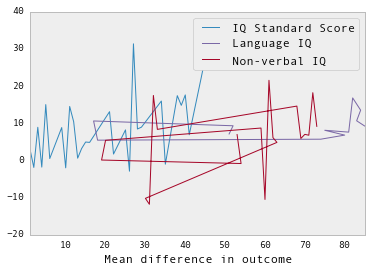

In [78]:
cognition_data_MA.groupby('cognition_outcome')['change_mean'].plot(kind='kde')
plt.xlabel('Mean difference in outcome');
plt.legend()

The three outcome measures are modeled as a multivariate normal random variable, to account for the likely correlation among the measures. Thus, we specify the mean vector and variance-covariance matrix with diffuse normal and Wishart priors, respectively.

In [53]:
with pm.Model() as model:
    mu = pm.Normal('mu', 0, 0.001, shape=3)
    Tau = pm.LK('Tau', 4, np.eye(3), shape=(3,3))

/usr/local/lib/python3.4/site-packages/pymc3/distributions/multivariate.py:165: UserWarning: The Wishart distribution can currently not be used for MCMC sampling. The probability of sampling a symmetric matrix is basically zero. Instead, please use the LKJCorr prior. For more information on the issues surrounding the Wishart see here: https://github.com/pymc-devs/pymc3/issues/538.
  warnings.warn('The Wishart distribution can currently not be used for MCMC sampling. The probability of sampling a symmetric matrix is basically zero. Instead, please use the LKJCorr prior. For more information on the issues surrounding the Wishart see here: https://github.com/pymc-devs/pymc3/issues/538.', UserWarning)


Thus, each study is a draw from a multivariate normal with the above parameters.

In [54]:
with model:
    
    m = [pm.MvNormal('m_{}'.format(i), mu, Tau, shape=3) for i in range(len(unique_studies))]

The parameters of interest are the indicators for each intervention category: 

- `high_intensity_eibi`
- `low_intensity_eibi`
- `low_intensity_parent_training`
- `defined_school_program`
- `high_intensity_community`
- `adjunctive_community_service`
- `eclectic_school`

Each study arm will have one or more of these indicators contributing to the response. We might like to have interactions among these parameters, but we likely do not have enough studies to fit all the additional parameters precisely.

In [55]:
with model:
    beta = pm.Normal('beta', 0, 0.001, shape=7)

In addition, since it appears there is a slight negative relationship between the treatment effect and the baseline score (see plot below), we model the mean baseline score for each treatment arm as a confounder.

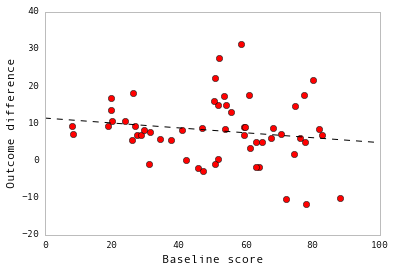

In [56]:
plot_data = cognition_data_MA[['after_mean', 'baseline_mean']].dropna()
x = plot_data.baseline_mean.values
y = (plot_data.after_mean - plot_data.baseline_mean).values
fit = np.polyfit(x, y, 1)
fit_fn = np.poly1d(fit)
xvals = np.linspace(0, 100)
plt.plot(x, y, 'ro', xvals, fit_fn(xvals), '--k')
plt.xlabel('Baseline score'); plt.ylabel('Outcome difference');

In [57]:
with model:
    
    alpha_base = pm.Normal('alpha_base', 0, 0.0001)

Putting this all together, the expected value for each result is the treatment effect mean for each outcome, along with the additive effects of treatment class and the baseline score effect.

In [59]:
import theano.tensor as tt

with model:
    mi = tt.stack([m[i][j] for i,j in zip(study_id, outcome_id)])

In [60]:
baseline_std = (baseline_mean - baseline_mean.mean())/baseline_mean.std()

In [61]:
with model:
    theta = mi + tt.dot(intervention_ind, beta) + alpha_base*baseline_std

Finally, the likelihood is just a normal distribution, with the observed standard error of the treatment effect as the standard deviation of the estimates.

In [62]:
change_se = change_sd/np.sqrt(n_analysis)

In [63]:
with model:
    d = pm.Normal('d', theta, change_se**-2, observed=change_mean)

Run the model using Markov chain Monte Carlo.

In [64]:
with model:
    step1 = pm.Metropolis(vars=m+[beta, Tau])
    step2 = pm.NUTS(vars=[alpha_base, mu])
    trace = pm.sample(20000, (step1,step2))

 [-----------------100%-----------------] 20000 of 20000 complete in 446.9 sec

/usr/local/Cellar/python3/3.4.2_1/Frameworks/Python.framework/Versions/3.4/lib/python3.4/importlib/_bootstrap.py:321: RuntimeWarning: numpy.ndarray size changed, may indicate binary incompatibility
  return f(*args, **kwds)


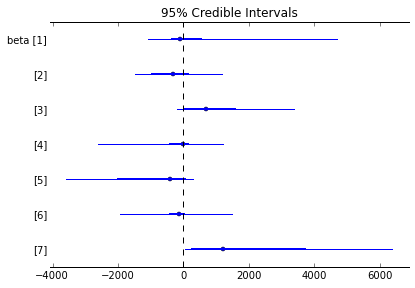

In [69]:
pm.forestplot(trace[10000:], vars=['beta'])

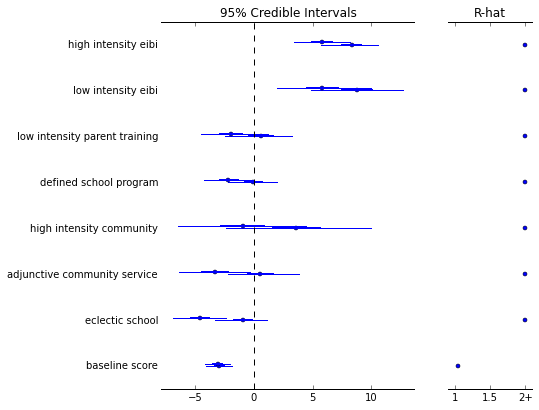

In [68]:
plt.figure(figsize=(10,6))
pm.Matplot.summary_plot([M.beta, M.alpha_base], custom_labels=[
                                     'high intensity eibi',
                                     'low intensity eibi',
                                     'low intensity parent training',
                                     'defined school program',
                                     'high intensity community',
                                     'adjunctive community service',
                                     'eclectic school',
                                     'baseline score'])

Could not calculate Gelman-Rubin statistics. Requires multiple chains of equal length.


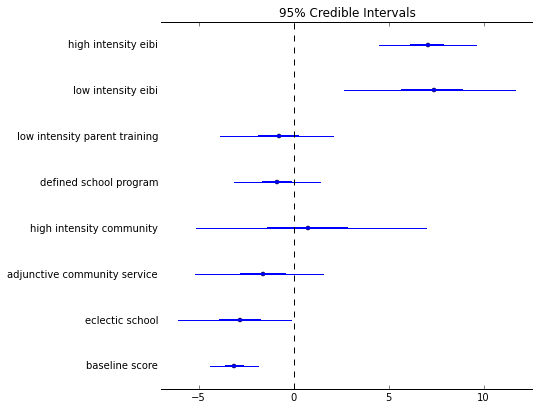

In [65]:
plt.figure(figsize=(10,6))
pm.Matplot.summary_plot([M.beta, M.alpha_base], custom_labels=[
                                     'high intensity eibi',
                                     'low intensity eibi',
                                     'low intensity parent training',
                                     'defined school program',
                                     'high intensity community',
                                     'adjunctive community service',
                                     'eclectic school',
                                     'baseline score'])

In [66]:
M.beta.summary()


beta:
 
	Mean             SD               MC Error        95% HPD interval
	------------------------------------------------------------------
	7.023            1.306            0.067            [ 4.492  9.575]
	7.286            2.316            0.142          [  2.664  11.644]
	-0.828           1.534            0.073            [-3.877  2.093]
	-0.878           1.161            0.059            [-3.128  1.4  ]
	0.75             3.129            0.143            [-5.108  6.946]
	-1.668           1.71             0.094            [-5.197  1.563]
	-2.868           1.541            0.108            [-6.071 -0.121]
	
	
	Posterior quantiles:
	
	2.5             25              50              75             97.5
	 |---------------|===============|===============|---------------|
	4.414            6.187           7.057          7.87          9.53
	2.675            5.687           7.364          8.839         11.758
	-3.961           -1.833          -0.773         0.23          2.032
	-3.203

Calculate posterior probability of best intervention.

In [67]:
M.best.summary()


best:
 
	Mean             SD               MC Error        95% HPD interval
	------------------------------------------------------------------
	0.449            0.497            0.02                   [ 0.  1.]
	0.538            0.499            0.02                   [ 0.  1.]
	0.0              0.0              0.0                    [ 0.  0.]
	0.0              0.0              0.0                    [ 0.  0.]
	0.013            0.112            0.002                  [ 0.  0.]
	0.0              0.0              0.0                    [ 0.  0.]
	0.0              0.0              0.0                    [ 0.  0.]
	
	
	Posterior quantiles:
	
	2.5             25              50              75             97.5
	 |---------------|===============|===============|---------------|
	0.0              0.0             0.0            1.0           1.0
	0.0              0.0             1.0            1.0           1.0
	0.0              0.0             0.0            0.0           0.0
	0.0         

Plotting beta_0
Plotting beta_1
Plotting beta_2
Plotting beta_3
Plotting beta_4
Plotting beta_5
Plotting beta_6


/usr/local/Cellar/python/2.7.6_1/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/numpy-1.9.0.dev_9c5109c-py2.7-macosx-10.9-x86_64.egg/numpy/core/fromnumeric.py:2499: VisibleDeprecationWarning: `rank` is deprecated; use the `ndim` attribute or function instead. To find the rank of a matrix see `numpy.linalg.matrix_rank`.
  VisibleDeprecationWarning)


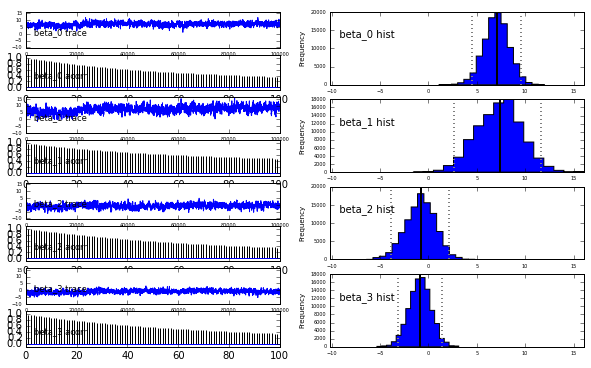

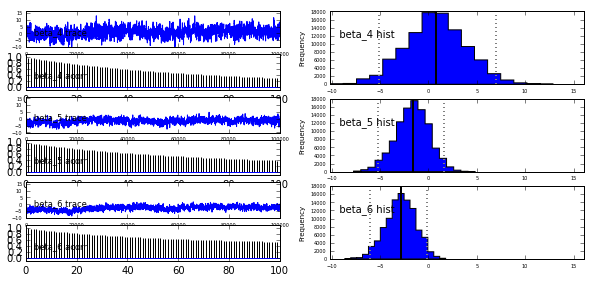

In [68]:
pm.Matplot.plot(M.beta)

Could not calculate Gelman-Rubin statistics. Requires multiple chains of equal length.


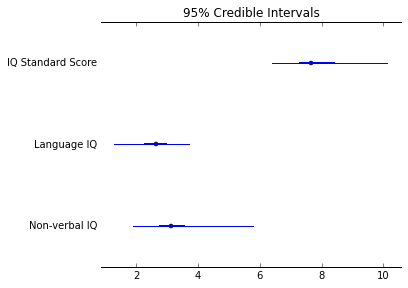

In [69]:
pm.Matplot.summary_plot([M.mu], custom_labels=outcomes_MA)

These posterior predictive plots illustrate the fit of the model. Each frame represents a study outcome, where the red line is the value of the observed mean outcome. The blue histograms are draws from the posterior predictive distribution of the model, so we look for cases where the red line is far outside the support of the simulated data as evidence for lack of fit. Here, the fit is reasonable across all study outcomes.

/usr/local/lib/python2.7/site-packages/matplotlib/pyplot.py:418: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_num_figures`).
  max_open_warning, RuntimeWarning)


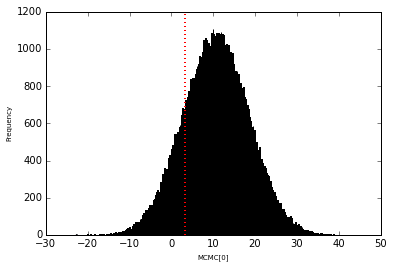

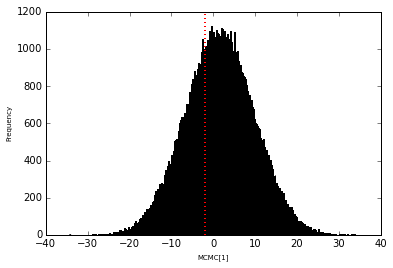

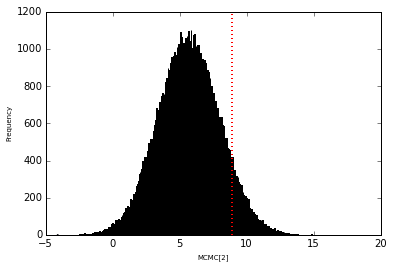

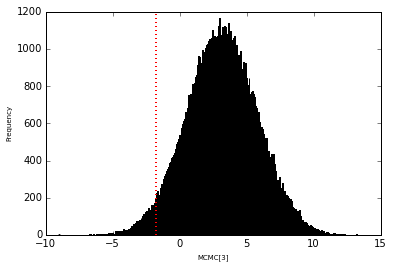

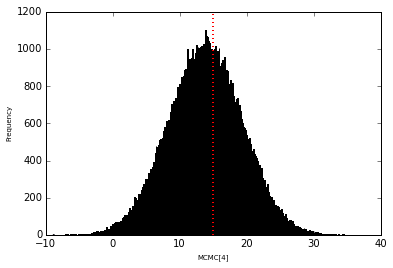

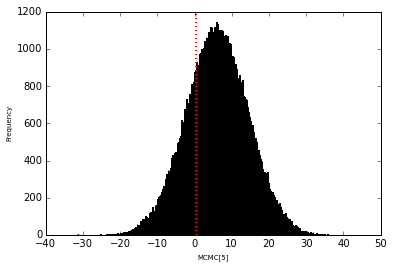

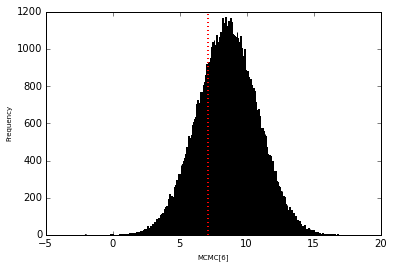

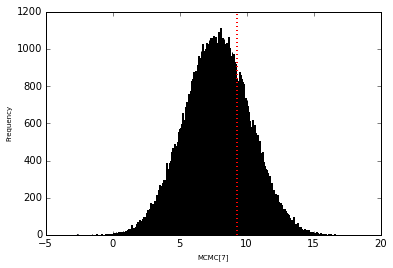

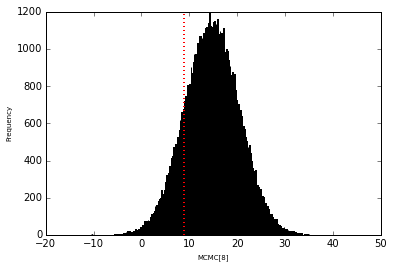

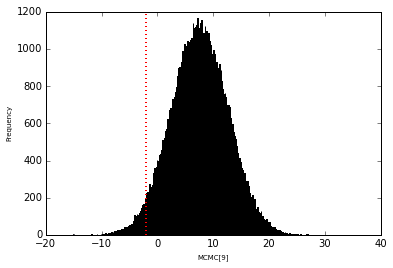

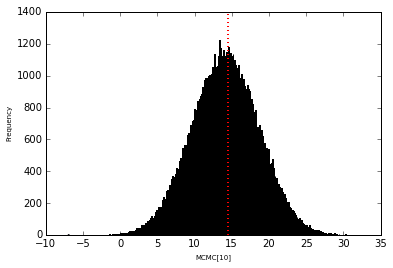

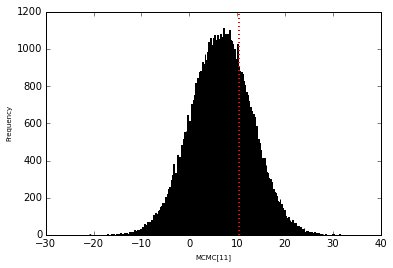

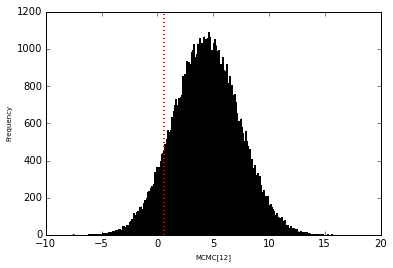

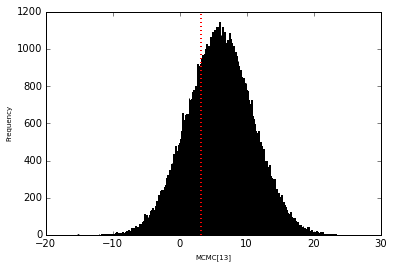

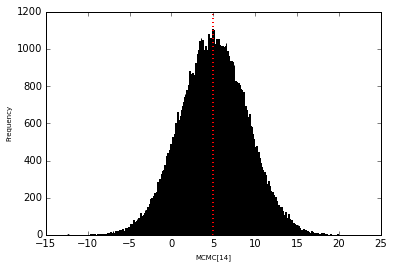

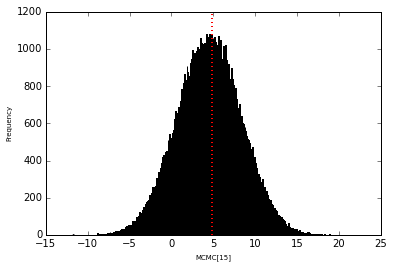

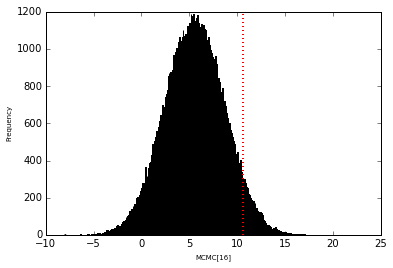

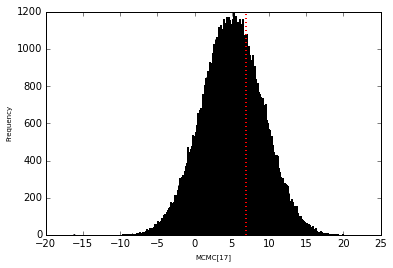

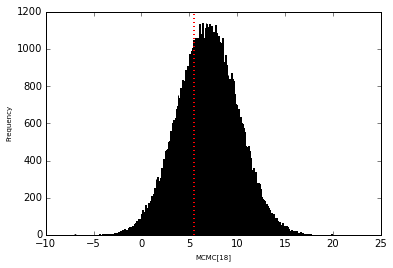

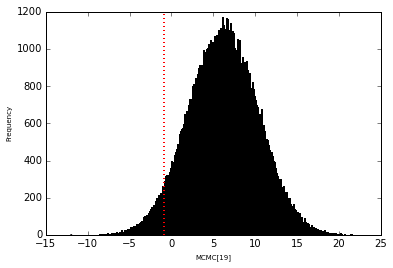

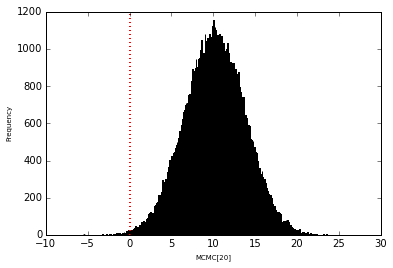

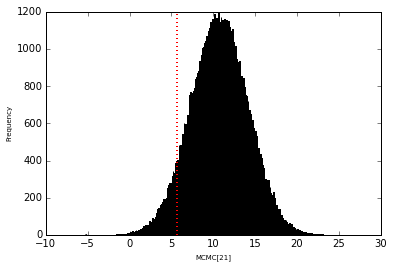

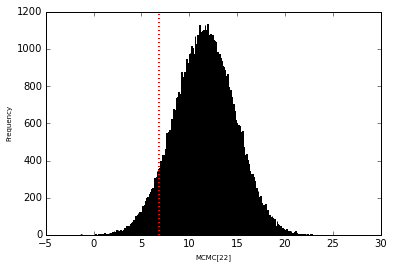

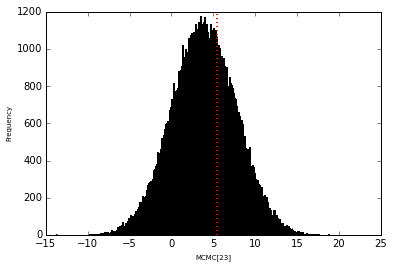

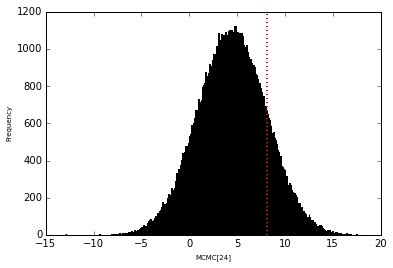

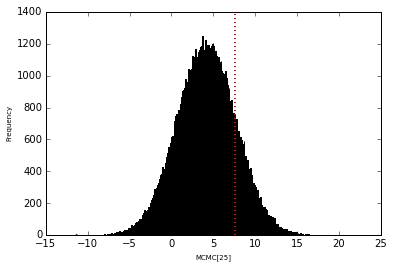

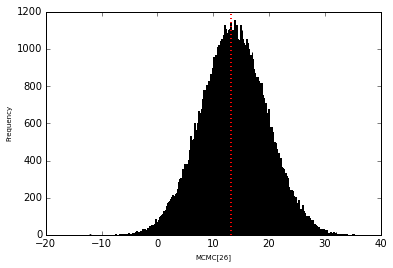

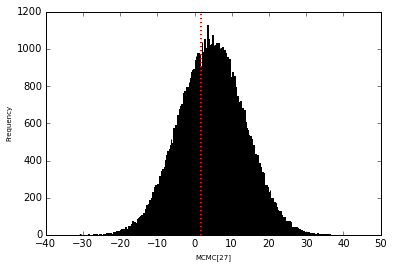

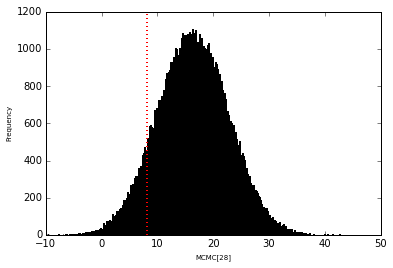

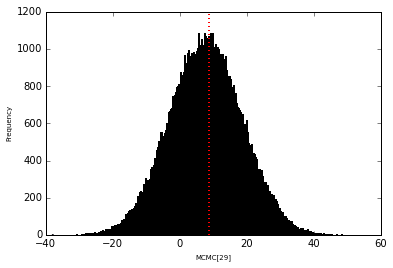

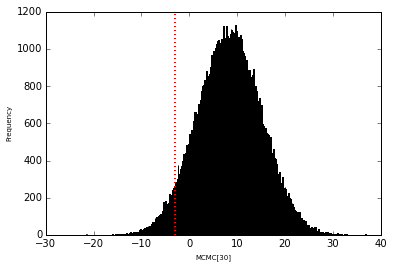

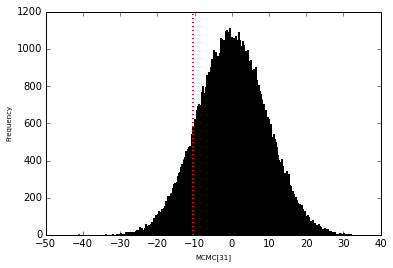

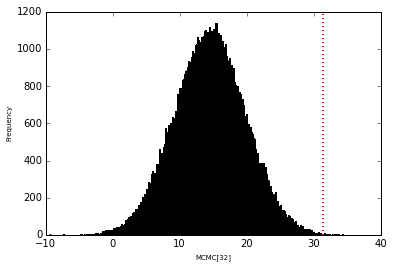

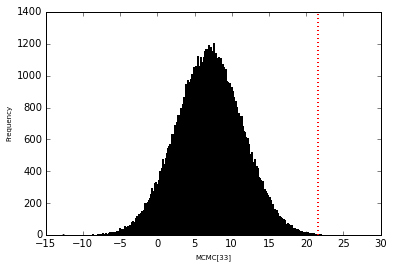

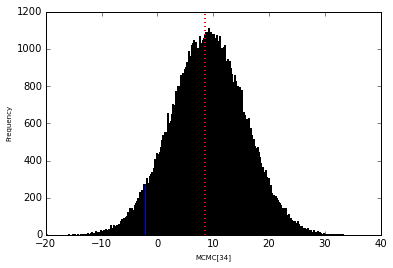

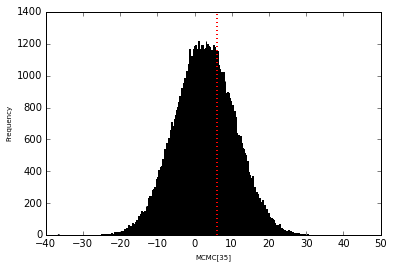

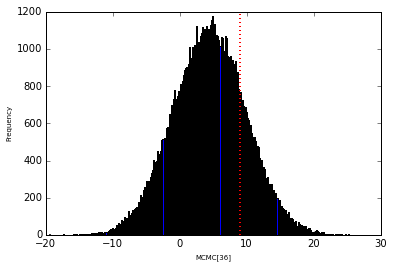

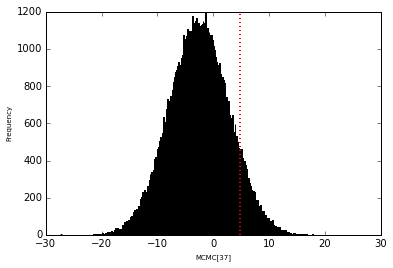

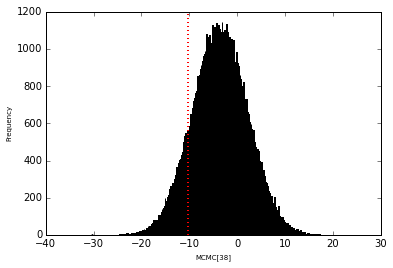

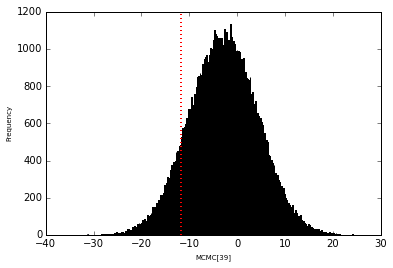

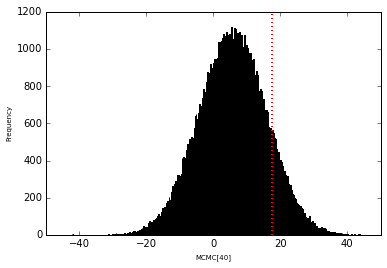

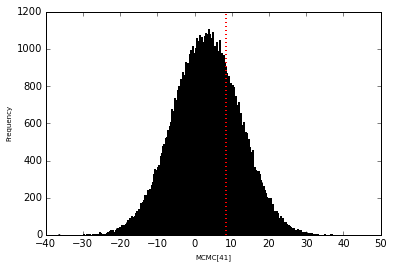

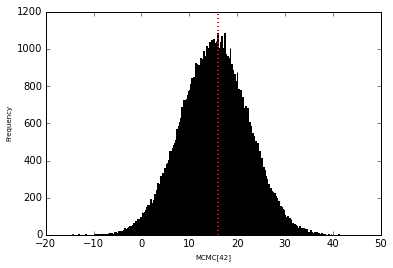

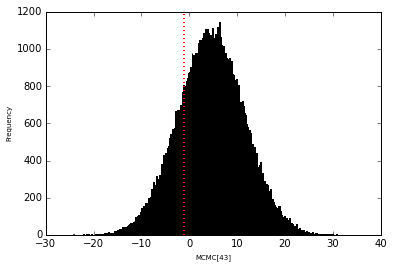

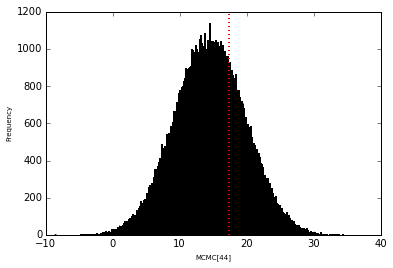

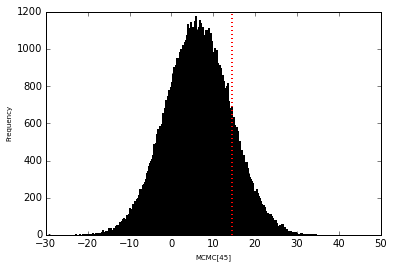

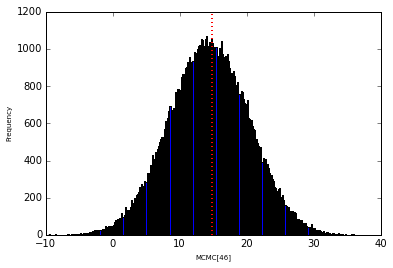

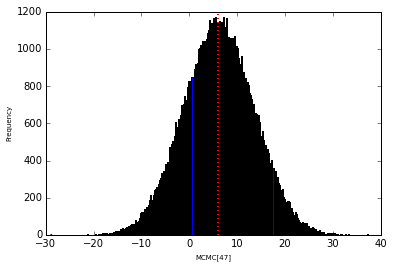

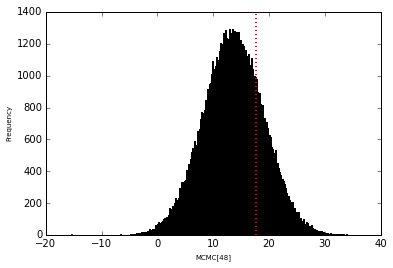

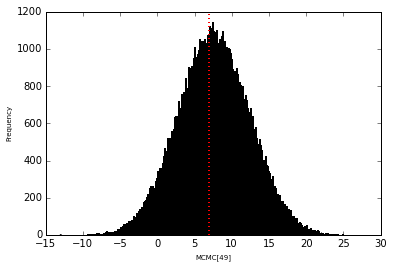

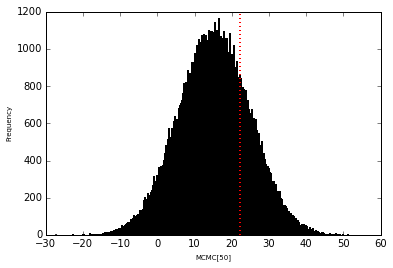

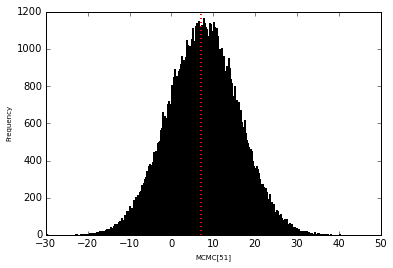

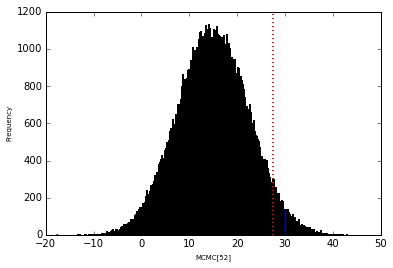

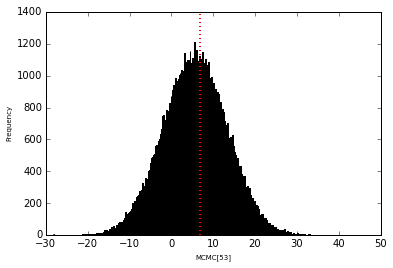

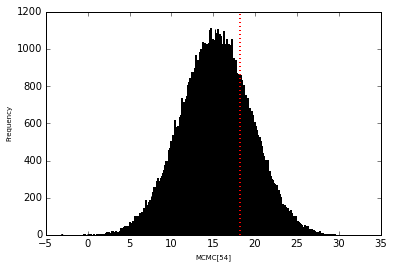

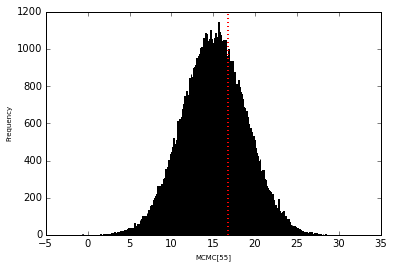

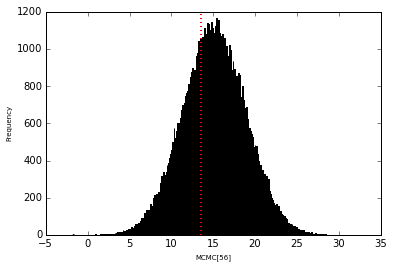

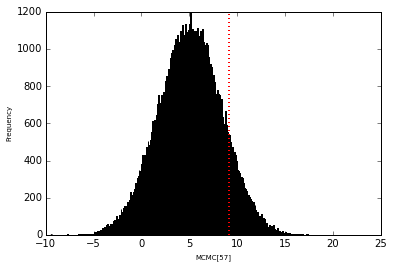

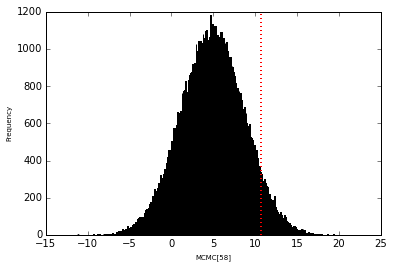

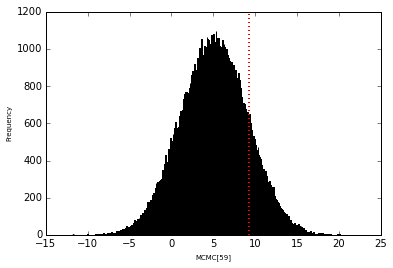

In [70]:
pm.Matplot.gof_plot(M.d_sim.trace(), change_mean, verbose=0)

In [93]:
def post_pred_checks(simdata, trueval, round=3):
    """
    Performs posterior predictive checks, returning the quantile of the observed data relative 
    to simulated.
    """

    if isinstance(simdata, pm.Variable):
        simdata = simdata.trace()

    if np.ndim(trueval) == 1 and np.ndim(simdata == 2):
        # Iterate over more than one set of data
        return [post_pred_checks(simdata[:,i], trueval[i]) for i in range(len(trueval))]
      
    return (simdata > trueval).mean()

In [94]:
ppp = post_pred_checks(M.d_sim.trace(), change_mean)

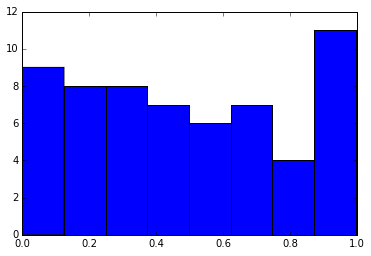

In [95]:
_ = plt.hist(ppp, bins=8)